In [21]:
%reset -sf

from time import time
time_start = time()

import pandas as pd
import numpy as np
import scipy as sp
import gc
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf

from flow import *
from utils import *

import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [22]:
seed = 42  # set random seed
sampling = int(1e3)
# num_folds = 2
batch_size = 64
epochs = 256
learning_rate = 1e-4

In [23]:
np.random.seed(seed)
processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [24]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [25]:
# inputs -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
obs_kin = pd.concat([MET, lep_kin], axis=1)
print("obs_kin shape:", obs_kin.shape)
print(obs_kin.head(3))
print()

# targets -> interested unknowns
int_kin = pd.DataFrame(
    processor.process_dipart(data.NuP, data.NuM)[["E", "pz"]][cut_pre]
)
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

obs_kin shape: (500, 10)
      MET_px     MET_py           E         px         py          pz  \
2   3.927378  33.916698   27.938791  21.373658 -13.679245 -248.614125   
4  25.296864   9.061190  196.946359 -56.337367  -6.376174  -29.247266   
7  60.893394  14.518041   91.805437   8.435755 -29.529184    1.504720   

            E         px         py          pz  
2   81.878680 -16.225992 -65.288852 -232.425141  
4  585.067500   4.052644   4.852154  -81.216570  
7  166.962094  -7.359001 -10.519515    5.960153  

int_kin shape: (500, 2)
            E         pz
2   35.211737 -52.328780
4  754.541109 -14.647291
7  180.349031 -20.424891



0

In [26]:
SCALAR_int = StandardScaler()
int_kin = SCALAR_int.fit_transform(int_kin)

SCALAR_obs = StandardScaler()
obs_kin = SCALAR_obs.fit_transform(obs_kin)

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, test_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.8,
    test_size=0.2,
    random_state=seed,
    shuffle=True,
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]

print(f"X:\nTraining data shape: {train_x.shape};\nTesting data shape: {test_x.shape}.")
print(f"Y:\nTraining data shape: {train_y.shape};\nTesting data shape: {test_y.shape}.")
print()

X:
Training data shape: (400, 10);
Testing data shape: (100, 10).
Y:
Training data shape: (400, 2);
Testing data shape: (100, 2).



In [27]:
# setup

# *hyperparameter
n_couple_layer = 3
n_hid_layer = 3
n_hid_dim = 128
learning_rate = 1e-4

# * hyperparameter
n_batch = 512
n_epoch = 512
n_display = n_batch

# * hyperparameter
w1 = 0.5  # related to pred loss
w2 = 25.0  # related to latent loss
w3 = 30.0  # related to rev loss
loss_factor = 1.0  # related to rev loss

# interest (momentum)
x_dim = train_x.shape[1]
# observed (MET)
y_dim = train_x.shape[1]

# * hyperparameter
z_dim = x_dim - y_dim # we only take intrinsic dimension into account
# z_dim = 3

tot_dim = y_dim + z_dim
pad_dim = tot_dim - x_dim

# Preprocess
## Pad data
X = train_x.reshape((-1, x_dim))
# print("pad_dim", pad_dim)
pad_x = np.zeros((X.shape[0], pad_dim))
print("pad_x", pad_x.shape)
# print("pad_x", pad_x.shape)
x = np.concatenate([X, pad_x], axis=-1).astype("float32")
print("x", x.shape)
z = np.random.multivariate_normal([0.0] * z_dim, np.eye(z_dim), X.shape[0]).astype(
    "float32"
)
y_hat = train_x.reshape(-1, y_dim)
print("y", y_hat.shape)
print("z", z.shape)
y = np.concatenate([z, y_hat], axis=-1).astype("float32")

print(f"Input dataset shape -> X:{x.shape}, Y: {y.shape}")

n_sample = X.shape[0]
print("n_sample", n_sample)
n_data = n_sample * train_x.shape[1]
print("n_data", n_data)
print()

# Make dataset generator
x_data = tf.data.Dataset.from_tensor_slices(x)
y_data = tf.data.Dataset.from_tensor_slices(y)
dataset = (
    tf.data.Dataset.zip((x_data, y_data))
    .shuffle(buffer_size=X.shape[0])
    .batch(n_batch, drop_remainder=True)
    .repeat()
)

pad_x (400, 0)
x (400, 10)
y (400, 2)
z (400, 8)
Input dataset shape -> X:(400, 10), Y: (400, 10)
n_sample 400
n_data 800



In [28]:
model = NVP(tot_dim, n_couple_layer, n_hid_layer, n_hid_dim, name="NVP")
x = tfk.Input((tot_dim,))
model(x)
model.summary()

Model: "NVP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer0 (TwoNVPCouplingLaye  multiple                  1067038   
 rs)                                                             
                                                                 
 Layer1 (TwoNVPCouplingLaye  multiple                  1067038   
 rs)                                                             
                                                                 
 Layer2 (TwoNVPCouplingLaye  multiple                  1067038   
 rs)                                                             
                                                                 
 Layer3 (TwoNVPCouplingLaye  multiple                  1067038   
 rs)                                                             
                                                                 
 Layer4 (TwoNVPCouplingLaye  multiple                  1067038 

In [29]:
class Trainer(tfk.Model):
    def __init__(
        self,
        model,
        x_dim,
        y_dim,
        z_dim,
        tot_dim,
        n_couple_layer,
        n_hid_layer,
        n_hid_dim,
        shuffle_type="reverse",
    ):
        super(Trainer, self).__init__()
        self.model = model
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.tot_dim = tot_dim
        self.x_pad_dim = tot_dim - x_dim
        self.y_pad_dim = tot_dim - (y_dim + z_dim)
        self.n_couple_layer = n_couple_layer
        self.n_hid_layer = n_hid_layer
        self.n_hid_dim = n_hid_dim
        self.shuffle_type = shuffle_type

        self.w1 = w1  # related to pred loss
        self.w2 = w2  # related to latent loss
        self.w3 = w3  # related to rev loss
        self.loss_factor = loss_factor  # related to rev loss
        self.loss_fit = MSE
        self.loss_latent = MMD_multiscale
        self.loss_backward = MMD_multiscale

    def train_step(self, data):
        x_data, y_data = data
        x = x_data[:, : self.x_dim]
        y = y_data[:, -self.y_dim :]
        z = y_data[:, : self.z_dim]
        y_short = tf.concat([z, y], axis=-1)

        # Forward loss
        with tf.GradientTape() as tape:
            y_out = self.model(x_data)
            pred_loss = self.w1 * self.loss_fit(
                y_data[:, self.z_dim :], y_out[:, self.z_dim :]
            )  # [zeros, y] <=> [zeros, yhat]
            output_block_grad = tf.concat(
                [y_out[:, : self.z_dim], y_out[:, -self.y_dim :]], axis=-1
            )  # take out [z, y] only (not zeros)
            latent_loss = self.w2 * self.loss_latent(
                y_short, output_block_grad
            )  # [z, y] <=> [zhat, yhat]
            forward_loss = pred_loss + latent_loss
        grads_forward = tape.gradient(forward_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads_forward, self.model.trainable_weights))

        # Backward loss
        with tf.GradientTape() as tape:
            x_rev = self.model.inverse(y_data)
            # rev_loss = self.w3 * self.loss_factor * self.loss_fit(x_rev, x_data)
            rev_loss = self.w3 * self.loss_factor * self.loss_backward(x_rev, x_data)
        grads_backward = tape.gradient(rev_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(
            zip(grads_backward, self.model.trainable_weights)
        )

        total_loss = forward_loss + latent_loss + rev_loss
        return {
            "total_loss": total_loss,
            "forward_loss": forward_loss,
            "latent_loss": latent_loss,
            "rev_loss": rev_loss,
        }

    def test_step(self, data):
        x_data, y_data = data
        return NotImplementedError

In [30]:
trainer = Trainer(
    model, x_dim, y_dim, z_dim, tot_dim, n_couple_layer, n_hid_layer, n_hid_dim
)
trainer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [31]:
# Load the TensorBoard notebook extension.
import datetime


LossFactor = UpdateLossFactor(n_epoch)
logger = NBatchLogger(n_display, n_epoch)

# set log file
%rm -r ./logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# set callback of tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=5, write_graph=True, write_images=False,)

hist = trainer.fit(
    dataset,
    batch_size=n_batch,
    epochs=n_epoch,
    steps_per_epoch=n_data // n_batch,
    callbacks=[logger, LossFactor, tensorboard_callback],
    verbose=2,
)

=== Started at 2023-12-12 09h:56m:36s ===
Epoch 1/128
 2023-12-12 09h:56m:50s | Epoch: 001/128 | total_loss=2.340330 forward_loss=1.405527 latent_loss=0.338451 rev_loss=0.596352
3/3 - 15s - total_loss: 2.3403 - forward_loss: 1.4055 - latent_loss: 0.3385 - rev_loss: 0.5964 - 15s/epoch - 5s/step
Epoch 2/128
3/3 - 0s - total_loss: 2.1135 - forward_loss: 1.2460 - latent_loss: 0.3282 - rev_loss: 0.5393 - 98ms/epoch - 33ms/step
Epoch 3/128
3/3 - 0s - total_loss: 2.1109 - forward_loss: 1.3095 - latent_loss: 0.3105 - rev_loss: 0.4908 - 107ms/epoch - 36ms/step
Epoch 4/128
3/3 - 0s - total_loss: 2.0161 - forward_loss: 1.2602 - latent_loss: 0.2948 - rev_loss: 0.4611 - 105ms/epoch - 35ms/step
Epoch 5/128
3/3 - 0s - total_loss: 2.0054 - forward_loss: 1.2876 - latent_loss: 0.2777 - rev_loss: 0.4401 - 109ms/epoch - 36ms/step
Epoch 6/128
3/3 - 1s - total_loss: 1.9094 - forward_loss: 1.2050 - latent_loss: 0.2743 - rev_loss: 0.4300 - 1s/epoch - 343ms/step
Epoch 7/128
3/3 - 0s - total_loss: 1.9892 - forw

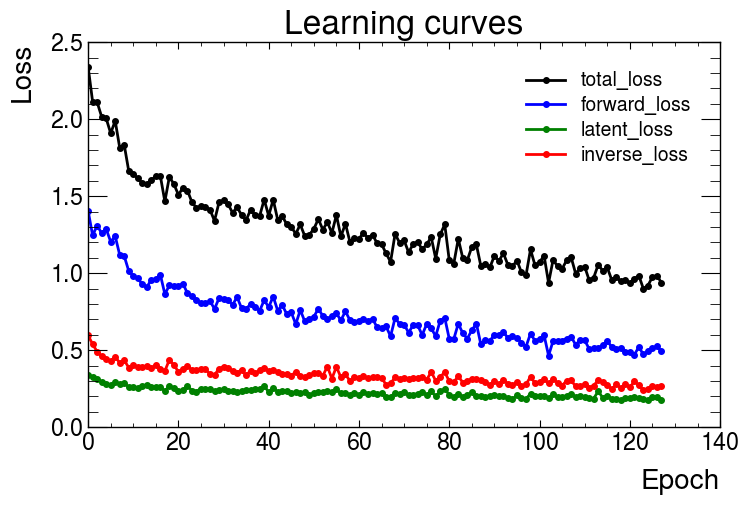

In [36]:
fig, ax = plt.subplots(1, facecolor="white", figsize=(8, 5))
ax.plot(hist.history["total_loss"], "k.-", label="total_loss")
ax.plot(hist.history["forward_loss"], "b.-", label="forward_loss")
ax.plot(hist.history["latent_loss"], "g.-", label="latent_loss")
ax.plot(hist.history["rev_loss"], "r.-", label="inverse_loss")
# plt.semilogy()
plt.legend()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("loss.png")
plt.show()
plt.close()

In [33]:
# Preprocess
z = np.random.multivariate_normal([1.0] * z_dim, np.eye(z_dim), test_y.shape[0])
y = np.concatenate([z, test_y], axis=-1).astype("float32")
y_pred = model.inverse(y).numpy()
print("y_pred", y_pred.shape)

sig_truth = test_x
sig_pred = y_pred

x_pred (100, 10)


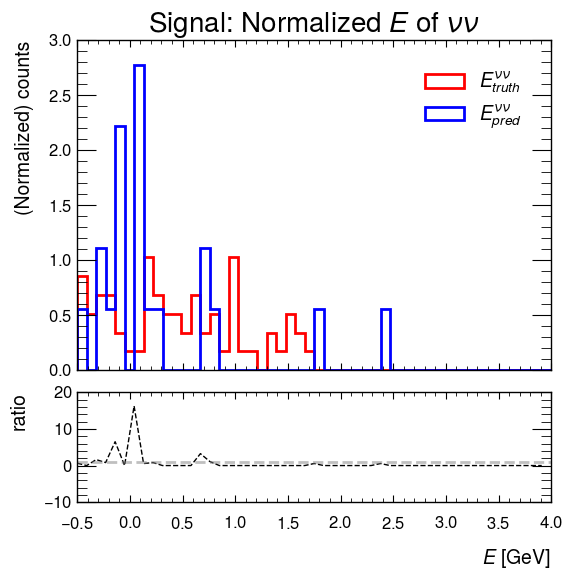

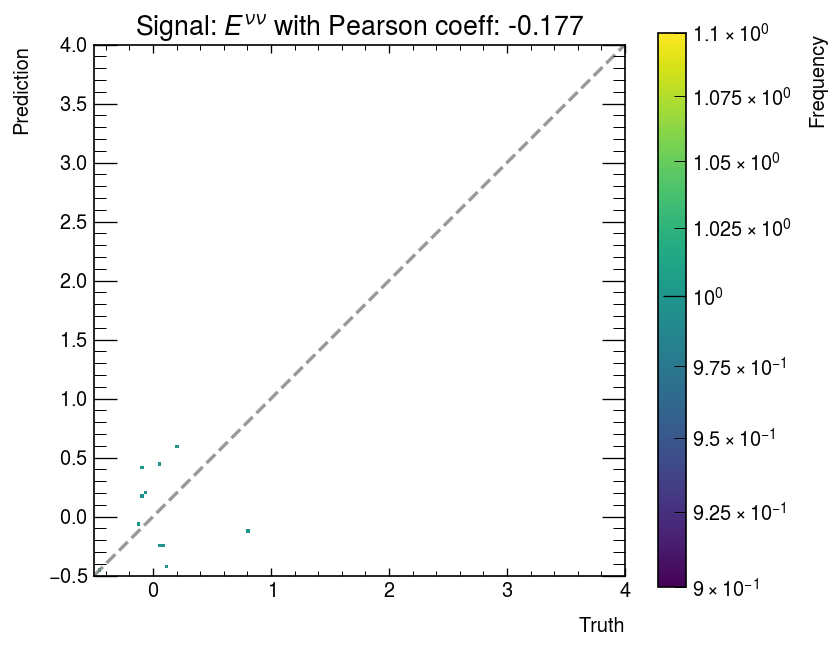

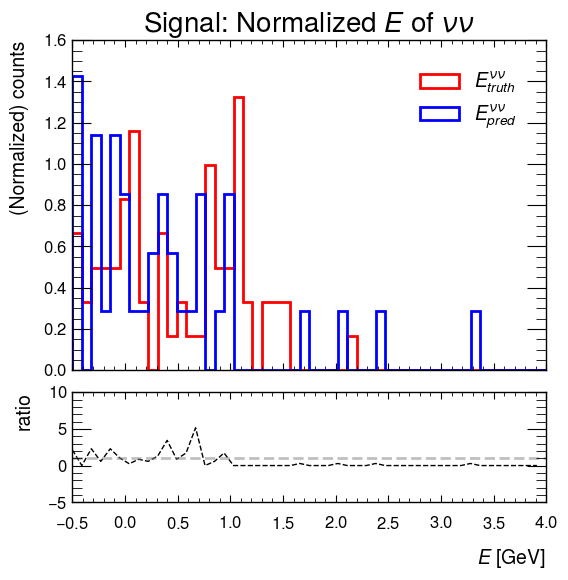

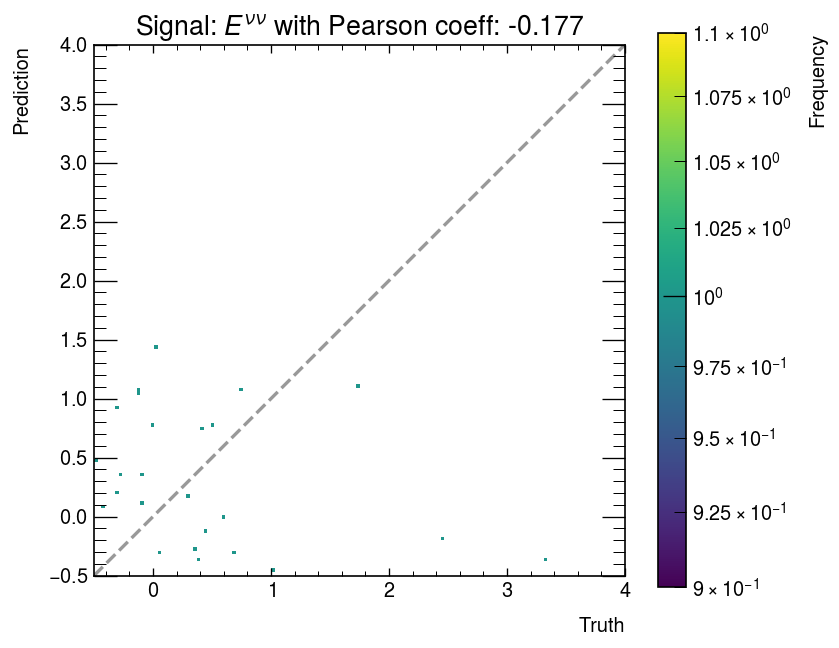

In [35]:
range = [-0.5, 4]

plot.plot_hist(
    [sig_truth[:, 0], sig_pred[:, 0]],
    [r"$E_{truth}^{\nu\nu}$", r"$E_{pred}^{\nu\nu}$"],
    r"Signal: Normalized $E$ of $\nu\nu$",
    range=range,
    xlabel=r"$E$ [GeV]",
)

plot.plot_2d_histogram(
    sig_pred[:, 0],
    sig_truth[:, 0],
    "Signal: "
    + r"$E^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,0], sig_pred[:,0])[0]:.3f}",
    range=range,
)

plot.plot_hist(
    [sig_truth[:, 1], sig_pred[:, 1]],
    [r"$E_{truth}^{\nu\nu}$", r"$E_{pred}^{\nu\nu}$"],
    r"Signal: Normalized $E$ of $\nu\nu$",
    range=range,
    xlabel=r"$E$ [GeV]",
)

plot.plot_2d_histogram(
    sig_pred[:, 1],
    sig_truth[:, 1],
    "Signal: "
    + r"$E^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,0], sig_pred[:,0])[0]:.3f}",
    range=range,
)